In [1]:
import torch
import torch.nn as nn
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.explain import Explanation
from torch_geometric.visualization import visualize_graph
from torch_geometric.datasets import TUDataset
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,global_mean_pool

from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.loader import DataLoader

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
device = 'cuda'

In [3]:
def compute_variance(H):
    """
    Computes the variance of the node feature matrix H (n x f).
    
    Parameters:
    H (torch.Tensor): n x f matrix of node feature vectors

    Returns:
    torch.Tensor: Variance of the node embeddings (scalar)
    """
    mean_vector = torch.mean(H, dim=0, keepdim=True)  # Compute mean across nodes
    variance = torch.mean(torch.norm(H - mean_vector, dim=1) ** 2)  # Compute variance
    return variance

In [4]:
from ogb.nodeproppred import PygNodePropPredDataset

In [5]:
"""
Graph: The ogbn-proteins dataset is an undirected, weighted, and typed (according to species) graph.
Nodes represent proteins, and edges indicate different types of biologically meaningful associations
between proteins, e.g., physical interactions, co-expression or homology [1,2]. All edges come with
8-dimensional features, where each dimension represents the approximate confidence of a single 
association type and takes values between 0 and 1 (the larger the value is, the more confident we are
about the association). The proteins come from 8 species.

Prediction task: The task is to predict the presence of protein functions in a multi-label binary 
classification setup, where there are 112 kinds of labels to predict in total. The performance is 
measured by the average of ROC-AUC scores across the 112 tasks.

Dataset splitting: We split the protein nodes into training/validation/test sets according to the 
species which the proteins come from. This enables the evaluation of the generalization performance of 
the model across different species.
"""

'\nGraph: The ogbn-proteins dataset is an undirected, weighted, and typed (according to species) graph.\nNodes represent proteins, and edges indicate different types of biologically meaningful associations\nbetween proteins, e.g., physical interactions, co-expression or homology [1,2]. All edges come with\n8-dimensional features, where each dimension represents the approximate confidence of a single \nassociation type and takes values between 0 and 1 (the larger the value is, the more confident we are\nabout the association). The proteins come from 8 species.\n\nPrediction task: The task is to predict the presence of protein functions in a multi-label binary \nclassification setup, where there are 112 kinds of labels to predict in total. The performance is \nmeasured by the average of ROC-AUC scores across the 112 tasks.\n\nDataset splitting: We split the protein nodes into training/validation/test sets according to the \nspecies which the proteins come from. This enables the evaluatio

In [6]:
dataset = PygNodePropPredDataset(name = "ogbn-proteins", root = 'data/')

D:\anaconda3\envs\pyg\Lib\site-packages\ogb\nodeproppred\dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

In [7]:

split_idx = dataset.get_idx_split()
split_idx

{'train': tensor([    0,     1,     2,  ..., 86616, 86617, 86618]),
 'valid': tensor([ 86619,  86620,  86621,  ..., 107852, 107853, 107854]),
 'test': tensor([107855, 107856, 107857,  ..., 132531, 132532, 132533])}

In [8]:
split_idx["train"].shape

torch.Size([86619])

In [9]:
split_idx["valid"].shape

torch.Size([21236])

In [10]:
split_idx["test"].shape

torch.Size([24679])

In [11]:
def nx_vis(graph):
    color_map = {
    (1, 0, 0): "red",
    (0, 1, 0): "green",
    (0, 0, 1): "blue",
    }
    g = pyg.utils.to_networkx(graph, to_undirected=True)
    
    node_color = [ color_map[tuple(graph.x[i].tolist())] for i in g ]
    
    nx.draw(g, node_color = node_color)

In [12]:
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]

In [13]:
graph = dataset[0]

In [14]:
graph

Data(num_nodes=132534, edge_index=[2, 79122504], edge_attr=[79122504, 8], node_species=[132534, 1], y=[132534, 112])

In [15]:
from torch_scatter import scatter
# Aggregate edge features to nodes (average)
node_features = scatter(graph.edge_attr, graph.edge_index[0], dim=0, dim_size=graph.num_nodes, reduce="mean")

In [16]:
node_features.shape

torch.Size([132534, 8])

In [17]:
graph.node_features = node_features

# Solve with MLP

In [39]:
features = graph.node_features
targets = graph.y

In [41]:
features.shape

torch.Size([132534, 8])

In [42]:
targets.shape

torch.Size([132534, 112])

In [132]:
class MLP(nn.Module):
    def __init__(self, in_dim=8, hidden_dim=256, out_dim=112):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc5 = nn.Linear(hidden_dim, out_dim)  # Output layer

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.fc1(x))  # First hidden layer
        #print(x.shape)
        x = F.relu(self.fc2(x))  # Second hidden layer
        #print(x.shape)
        x = F.relu(self.fc3(x))  # Second hidden layer
        #print(x.shape)
        x = F.relu(self.fc4(x))  # Second hidden layer
        #print(x.shape)
        x = self.fc5(x)
        return x

In [133]:
train_x = features[train_idx]
train_y = targets[train_idx]
train_data = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_data,batch_size=32, shuffle=True)

In [134]:
val_x = features[valid_idx]
val_y = targets[valid_idx]

val_data = TensorDataset(val_x, val_y)
val_loader = DataLoader(val_data,batch_size=32, shuffle=True)

In [135]:
test_x = features[test_idx]
test_y = targets[test_idx]

test_data = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_data,batch_size=32, shuffle=True)

In [144]:
model = MLP()
model.to(device)

MLP(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=112, bias=True)
)

In [145]:
criterion=nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 50

In [146]:
# Training function
def train(model):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)  # Raw logits
        loss = criterion(y_pred.float(), y_batch.float())  # BCEWithLogitsLoss applies sigmoid internally

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    return total_loss / len(train_loader)  # Average loss per batch

In [147]:
# Evaluation function (returns validation loss and ROC-AUC)
def val(model):
    model.eval()
    total_loss = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)  # Raw logits

            loss = criterion(y_pred.float(), y_batch.float())
            total_loss += loss.item()

            all_y_true.append(y_batch.cpu())
            all_y_pred.append(torch.sigmoid(y_pred).cpu())  # Convert logits to probabilities

    # Convert lists to tensors
    all_y_true = torch.cat(all_y_true).numpy()
    all_y_pred = torch.cat(all_y_pred).numpy()

    # Compute ROC-AUC per label
    auc_scores = []
    for i in range(all_y_true.shape[1]):
        if len(set(all_y_true[:, i])) > 1:  # Ensure at least two classes exist
            auc_scores.append(roc_auc_score(all_y_true[:, i], all_y_pred[:, i]))

    val_auc = sum(auc_scores) / len(auc_scores)  # Macro-average AUC

    return total_loss / len(val_loader), val_auc  # Return validation loss & accuracy (AUC)

In [148]:
def train_model(model, epochs = 50):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val = float('inf')
    for i in range(epochs):
        train_loss = train(model)
        val_loss, val_auc = val(model)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_auc)
        if val_loss<best_val:
            best_val = val_loss
            torch.save(model.state_dict(),'MLP.pt')
        print(f"Epoch {i+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    return train_losses, val_losses, val_accs

In [149]:
train_losses, val_losses, val_aucs = train_model(model)

Epoch 1/50 - Train Loss: 0.3202, Val Loss: 0.3884, Val AUC: 0.7132
Epoch 2/50 - Train Loss: 0.2978, Val Loss: 0.3756, Val AUC: 0.7423
Epoch 3/50 - Train Loss: 0.2908, Val Loss: 0.3717, Val AUC: 0.7545
Epoch 4/50 - Train Loss: 0.2870, Val Loss: 0.3720, Val AUC: 0.7536
Epoch 5/50 - Train Loss: 0.2841, Val Loss: 0.3725, Val AUC: 0.7622
Epoch 6/50 - Train Loss: 0.2818, Val Loss: 0.3650, Val AUC: 0.7690
Epoch 7/50 - Train Loss: 0.2801, Val Loss: 0.3688, Val AUC: 0.7708
Epoch 8/50 - Train Loss: 0.2784, Val Loss: 0.3723, Val AUC: 0.7687
Epoch 9/50 - Train Loss: 0.2773, Val Loss: 0.3676, Val AUC: 0.7717
Epoch 10/50 - Train Loss: 0.2758, Val Loss: 0.3618, Val AUC: 0.7733
Epoch 11/50 - Train Loss: 0.2746, Val Loss: 0.3665, Val AUC: 0.7724
Epoch 12/50 - Train Loss: 0.2734, Val Loss: 0.3621, Val AUC: 0.7744
Epoch 13/50 - Train Loss: 0.2723, Val Loss: 0.3593, Val AUC: 0.7792
Epoch 14/50 - Train Loss: 0.2713, Val Loss: 0.3610, Val AUC: 0.7808
Epoch 15/50 - Train Loss: 0.2702, Val Loss: 0.3658, Val A

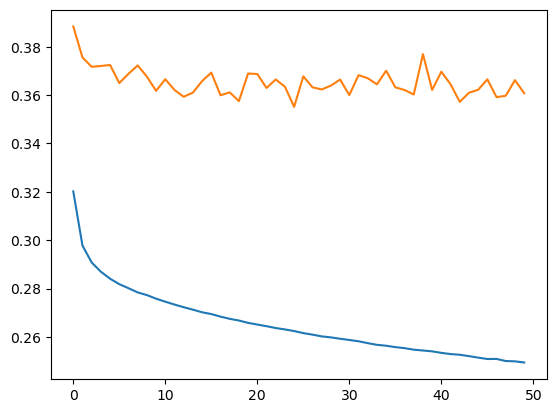

In [151]:
plt.plot(train_losses)
plt.plot(val_losses)

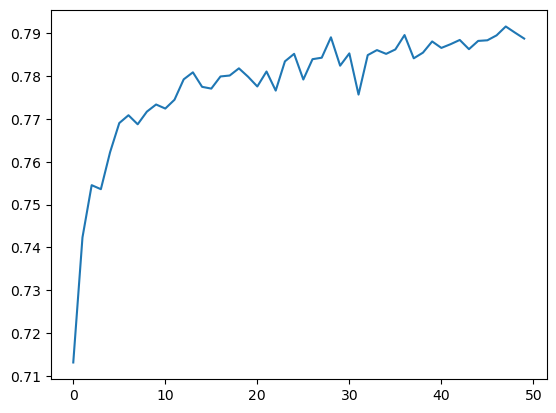

In [154]:
plt.plot(val_aucs)

In [155]:
history = {
    "train_loss":train_losses,
    "val_loss": val_losses,
    "val_auc": val_aucs
}
           

In [156]:
torch.save(history, 'MLP_history.pt')

In [ ]:
class GCN(nn.Module, dropout):
    def __init__(self, in_dim=8, hidden_dim=256, out_dim=112):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc5 = nn.Linear(hidden_dim, out_dim)  # Output layer

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.fc1(x))  # First hidden layer
        #print(x.shape)
        x = F.relu(self.fc2(x))  # Second hidden layer
        #print(x.shape)
        x = F.relu(self.fc3(x))  # Second hidden layer
        #print(x.shape)
        x = F.relu(self.fc4(x))  # Second hidden layer
        #print(x.shape)
        x = self.fc5(x)
        return x

In [162]:
train_data[0]

(tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0533, 0.0239, 0.0010, 0.2182]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
         1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
         1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features=8, hidden_dim=64, num_classes=112, num_layers=3, 
                 edge_dropout=0.2):
        """
        GCN model with flexible depth, dropout, and edge dropout.
        
        Args:
            num_features (int): Input feature size (e.g., 8 for ogbn-proteins).
            hidden_dim (int): Hidden layer size.
            num_classes (int): Output size (e.g., 112 for multi-label classification).
            num_layers (int): Number of GCN layers.
            dropout (float): Node dropout rate (0.0 - 1.0).
            edge_dropout (float): Edge dropout rate (0.0 - 1.0).
        """
        super(GCN, self).__init__()
        
        self.num_layers = num_layers
        self.edge_dropout = edge_dropout
        self.convs = torch.nn.ModuleList()
        self.dropout = Dropout(dropout)

        # Input layer
        self.convs.append(GCNConv(num_features, hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        # Output layer
        self.convs.append(GCNConv(hidden_dim, num_classes))

    def forward(self, x, edge_index):
        # Apply edge dropout
        edge_index, _ = dropout_edge(edge_index, p=self.edge_dropout, training=self.training)

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)  # GCN layer
            if i < len(self.convs) - 1:  # Apply ReLU + Dropout to all but last layer
                x = F.relu(x)
                x = self.dropout(x)
        
        return x  # No activation on final layer (for AUC computation)

In [163]:
graph

Data(num_nodes=132534, edge_index=[2, 79122504], edge_attr=[79122504, 8], node_species=[132534, 1], y=[132534, 112], node_features=[132534, 8])

In [164]:
def filter_edges(edge_index, node_idx):
    """
    Filters edge_index to only keep edges where both nodes are in node_idx.

    Args:
        edge_index (torch.Tensor): Shape [2, num_edges], contains edge connections.
        node_idx (torch.Tensor): Indices of nodes belonging to the split.

    Returns:
        torch.Tensor: Filtered edge_index for the given node set.
    """
    mask = torch.isin(edge_index[0], node_idx) & torch.isin(edge_index[1], node_idx)
    return edge_index[:, mask]

In [165]:
train_edges = filter_edges(graph.edge_index, train_idx)

In [167]:
train_edges.shape

torch.Size([2, 40846716])

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_scatter import scatter_add

class CustomGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomGCNConv, self).__init__()
        self.W = nn.Linear(in_channels, out_channels, bias=False)  # Learnable weight matrix

    def forward(self, x, edge_index):
        """
        x: Node features of shape (N, F_in)
        edge_index: Sparse adjacency list of shape (2, E)
        """
        x = x.half()
        #print(f'Forward: {edge_index}')
        row, col = edge_index  # Get source and target nodes
        
        # Compute degree normalization (D^(-1/2))
        deg = scatter_add(torch.ones_like(row, dtype=x.dtype), row, dim=0, dim_size=x.size(0))  # Degree of each node
        print(deg.shape)
        deg_inv_sqrt = deg.pow(-0.5)
        print(deg_inv_sqrt.shape)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0  # Avoid division by zero
        print('right before norm')
        # Normalize message passing: D^(-1/2) * A * D^(-1/2) * X
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        print(norm.shape)
        x_j = x[col] * norm.view(-1, 1)  # Scale features by normalized adjacency
        print(x_j.shape)
        agg = scatter_add(x_j, row, dim=0, dim_size=x.size(0))  # Aggregate messages
        print(agg.shape)
        del x_j
        del norm
        del deg_inv_sqrt
        del deg
        return self.W(agg)  # Apply transformation



In [24]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(
            CustomGCNConv(in_channels, hidden_channels, normalize=False))
        for _ in range(num_layers - 2):
            self.convs.append(
                CustomGCNConv(hidden_channels, hidden_channels, normalize=False))
        self.convs.append(
            CustomGCNConv(hidden_channels, out_channels, normalize=False))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            #x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x
        

In [25]:
graph

Data(num_nodes=132534, edge_index=[2, 79122504], edge_attr=[79122504, 8], node_species=[132534, 1], y=[132534, 112], node_features=[132534, 8])

In [86]:
edges = graph.edge_index

In [90]:
edges.shape
#log2(...) = 26.2375847482
# we are restricted to 25-26 epochs under this scheme

torch.Size([2, 79122504])

In [28]:
from torch_geometric.utils.dropout import dropout_edge


In [34]:
graph

Data(num_nodes=132534, edge_index=[2, 79122504], edge_attr=[79122504, 8], node_species=[132534, 1], y=[132534, 112], node_features=[132534, 8])

In [91]:
edges, edge_mask = dropout_edge(edges)

In [92]:
edges.shape

torch.Size([2, 39567037])

In [85]:
edge_mask.shape

torch.Size([160])

In [36]:
model = GCN(8,256,112,2,0.5)

In [93]:
model(graph.node_features, edges)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 40516645888 bytes.

In [23]:
x  =graph.node_features
conv = CustomGCNConv(in_channels=8, out_channels=112)
x_out = conv(x, graph.edge_index)  # Uses sparse edge representation
print(x_out.shape)  # Output node embeddings

torch.Size([132534])
torch.Size([132534])
right before norm
torch.Size([79122504])
torch.Size([79122504, 8])
torch.Size([132534, 8])
torch.Size([132534, 112])


In [22]:
x = graph.node_features
x.shape

torch.Size([132534, 8])

In [24]:
x.float().dtype

torch.float32

In [26]:
a = torch.rand((5,5))

In [30]:
b = a.half()

In [32]:
b*a

tensor([[0.2485, 0.0365, 0.5966, 0.3405, 0.3526],
        [0.3174, 0.2991, 0.5675, 0.2685, 0.0399],
        [0.0367, 0.1123, 0.8734, 0.7993, 0.1175],
        [0.3231, 0.8088, 0.8453, 0.7379, 0.0045],
        [0.6784, 0.0047, 0.6721, 0.9347, 0.1530]])